In [1]:
import FinObj as fin
import numpy as np
import riskEngine as risk
import smoothing as smooth

In [2]:
#Map for units of time
t_map = {'2y':0.5,'year':1,'semester':2,'quarter':4,'month':12,'week':52,'2day':180,'day':360}

In [3]:
#MC Parameters
paths = 5000
t_del = 1

t_unit = 12 #Unit of time: default = 1 for years, 12 for months, 360 for days etc...
call_dates = 4 #Number of call dates per unit time
time_s = 12 #Total number of time steps in t_units

In [4]:
#Stock Parameters
spot = 120
vol = 0.2 #vol per year
rate = 0 #Rate in years

#Share object
share1 = fin.Stock(spot,vol,t_unit)

In [5]:
#Autocall Parameters
C = 0.25 #Annual rate coupon
ssize = 1 #Notional
downin = 0.7 #Put down and in
mature = time_s #Maturity (initially assume last day of time step)
strike = 100 #Strike price


#autocall object
autoc = fin.AutoCall(share1, C, fin.schFixed, ssize, downin, mature, strike, call_dates, t_unit)

In [6]:
t_iter=risk.getThetaIter(share1,autoc,paths,time_s,t_del)

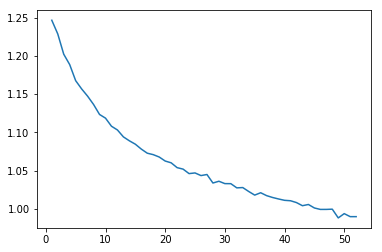

In [7]:
#Plot price against time
import matplotlib.pyplot as pplot
pplot.plot(t_iter.keys(), t_iter.values())
pplot.show()

In [9]:
#Smoothing factors for theta
from scipy.optimize import curve_fit

popt, pcov = curve_fit(smooth.genExp, list(t_iter.keys()), list(t_iter.values()),p0=[1,-1,1,1])

In [10]:
#Computed smoothed prices
fitted_iter = [smooth.genExp(x, *popt) for x in t_iter.keys()]

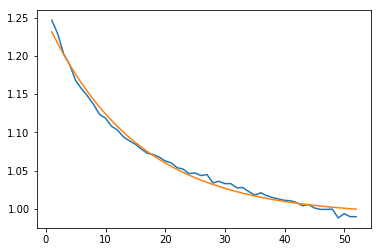

In [11]:
#Plot fitted values
pplot.plot(t_iter.keys(), t_iter.values())
pplot.plot(t_iter.keys(), fitted_iter)
pplot.show()

In [22]:
#######################################################################
#################### Compute theta with one time step #################
#######################################################################
theta_times = [(360/x,x) for x in range(1,361)] #Units match t_unit
t_prices = risk.getTheta(share1,autoc,paths, time_s, t_del, theta_times)

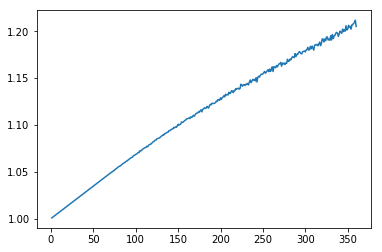

In [23]:
#Plot price against time
import matplotlib.pyplot as pplot
pplot.plot(t_prices.keys(), t_prices.values())
pplot.show()


In [8]:
#Smoothing factors for theta
from scipy.optimize import curve_fit

popt, pcov = curve_fit(smooth.genPol, list(t_prices.keys()), list(t_prices.values()))

/Users/anthonymaylath/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [9]:
#Computed smoothed prices
fitted_t = [smooth.genPol(x, *popt) for x in t_prices.keys()]

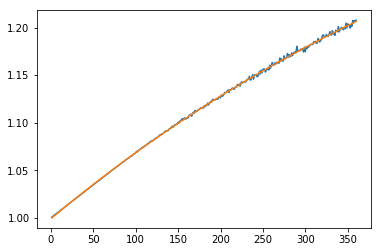

In [10]:
#Plot fitted values
pplot.plot(t_prices.keys(), t_prices.values())
pplot.plot(t_prices.keys(), fitted_t)
pplot.show()

In [11]:
#Plot smoothed derivative
theta = [smooth.derPol(x, *popt) for x in t_prices.keys()]
pplot.plot(t_prices.keys(), theta)
pplot.show()

TypeError: derPol() takes 5 positional arguments but 6 were given

In [51]:
#Get price over several spots
maxi, mini = 125, 50 #Max and min values
resolution = 50 #Number of grid points
spots = np.linspace(mini,maxi,resolution)
prices = risk.getSpot(share1,autoc,paths,time_s,t_del,spots)

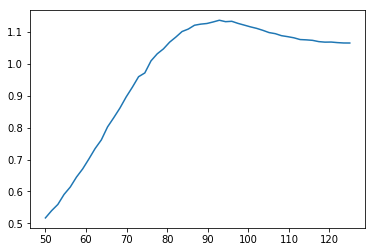

In [52]:
import matplotlib.pyplot as pplot
pplot.plot(prices.keys(), prices.values())
pplot.show()

In [66]:
#Fit spots to a curve
from scipy.optimize import curve_fit 
popt, pcov = curve_fit(smooth.genSig, list(prices.keys()), list(prices.values()), p0=[1,90,1,1])

In [67]:
#Computed smoothed prices
fitted = [smooth.genSig(x, *popt) for x in prices.keys()]

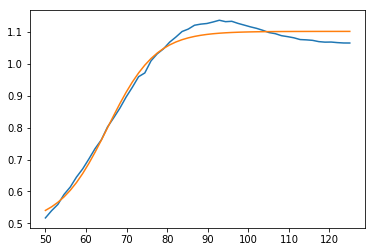

In [68]:
pplot.plot(prices.keys(), prices.values())
pplot.plot(prices.keys(), fitted)
pplot.show()

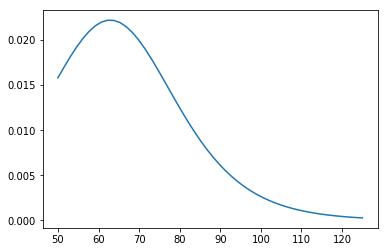

In [18]:
#Plot smoothed deltas
delta_smooth = [smooth.derSig(x, *popt) for x in prices.keys()]
pplot.plot(prices.keys(), delta_smooth)
pplot.show()

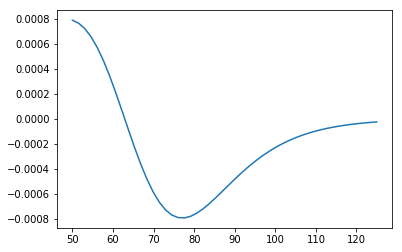

In [20]:
#Plot Smoothed gammas
gamma_smooth = [smooth.gammaSig(x, *popt) for x in prices.keys()]
pplot.plot(prices.keys(), gamma_smooth)
pplot.show()

In [96]:
#Get numerical delta
len_spot = len(spots)
deltas = {spots[x]:(prices[spots[x+1]]-prices[spots[x-1]])/(spots[x+1]-spots[x-1])\
                                          for x in range(1,len_spot-1)}

In [98]:
#Get Numerical gamma
gamma = {spots[x]:(prices[spots[x+1]]+prices[spots[x-1]]-2*prices[spots[x]])\
                             /(spots[x+1]-spots[x-1])*(spots[x+1]-spots[x-1])/4\
                                          for x in range(1,len_spot-1)}

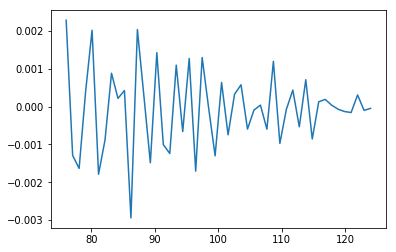

In [99]:
import matplotlib.pyplot as pplot
pplot.plot(gamma.keys(), gamma.values())
pplot.show()

In [6]:
###############################################
#########      Vega ###########################
maxi, mini = 0.9, 0.05 #Max and min values
resolution = 50 #Number of grid points
vols = np.linspace(mini,maxi,resolution)
prices_v = risk.getVol(share1,autoc,paths,time_s,t_del,vols,2)

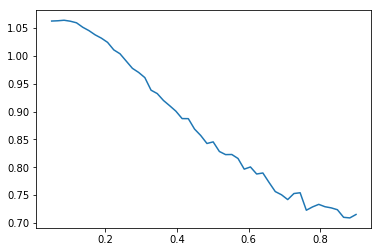

In [7]:
import matplotlib.pyplot as pplot
pplot.plot(prices_v.keys(), prices_v.values())
pplot.show()

In [18]:
#Fit vegas to a curve
from scipy.optimize import curve_fit 
popt, pcov = curve_fit(smooth.genExp, list(prices_v.keys()), list(prices_v.values()),p0=[1,-1,0,1])

In [21]:
#Computed smoothed prices
fitted_v = [smooth.genExp(x, *popt) for x in prices_v.keys()]

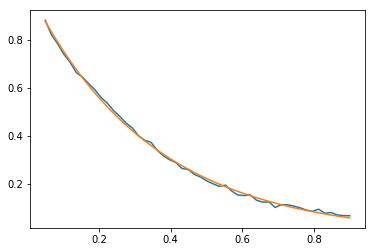

In [22]:
pplot.plot(prices_v.keys(), prices_v.values())
pplot.plot(prices_v.keys(), fitted_v)
pplot.show()

In [72]:
#Try piecewise function
from scipy.interpolate import interp1d
xint = list(prices_v.keys())[0::7]
yint = list(prices_v.values())[0::7]
f2 = interp1d(xint, yint, kind='cubic')

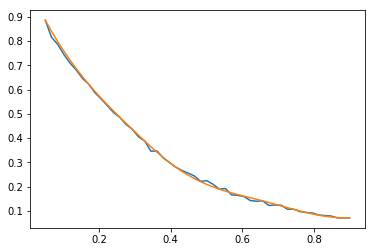

In [73]:
pplot.plot(prices_v.keys(), prices_v.values())
pplot.plot(prices_v.keys(), f2(list(prices_v.keys())))
pplot.show()

In [74]:
#Get vega of smoothed function
len_vol = len(vols)
vega_s = {vols[x]:(f2(vols[x+1])-f2(vols[x-1]))/(vols[x+1]-vols[x-1])/100\
                                          for x in range(1,len_vol-1)}

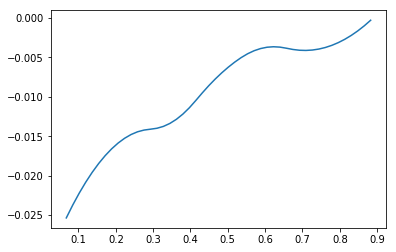

In [75]:
pplot.plot(vega_s.keys(), vega_s.values())
pplot.show()

In [76]:
#Numerical vega (scale to percentage) directly on valuation (could be noisy)
vega = {vols[x]:(prices[vols[x+1]]-prices[vols[x-1]])/(vols[x+1]-vols[x-1])/100\
                                          for x in range(1,len_vol-1)}

KeyError: 0.08469387755102041